In [79]:
# Import libaries
import re


In [80]:
# Libary to import self-made libaries
import sys # https://stackoverflow.com/questions/4383571/importing-files-from-different-folder
sys.path.insert(1, r'C:\Users\ruw\Desktop\RA\Single-use-vs-multi-use-in-health-care\Brighway\Libaries')

In [81]:
# Importing self-made libaries
import standards as s
import Monte_Carlo as MC
import life_cycle_assessment as lc
import LCA_plots as lp
import box_plot as bp
import reload_lib as rl


lib = [s, MC, lc, lp, bp]

In [82]:
# Path to where the code is stored
path = r'C:\Users\ruw\Desktop\RA\Single-use-vs-multi-use-in-health-care\Brighway'
# Specifying the LCIA method
lcia_method = 'recipe'
rl.reload_lib(lib)
flow_legend, database_name, file_name, sheet_name, save_dir, initialization, file_name_unique, db_type = lc.initilization(path, lcia_method)

The chosen project is SU_vs_MU and the chosen database is sterilization
Folder name Results created
Chosen flows:
H200 REC - CONSQ
H200 SU - CONSQ
H400 REC- CONSQ
H400 SU - CONSQ
alubox large + washer - CONSQ
alubox large + wipe - CONSQ
alubox small + washer - CONSQ
alubox small + wipe - CONSQ


In [83]:
df, plot_x_axis_all, impact_categories = lc.quick_LCIA(initialization, file_name, file_name_unique, sheet_name)

Recipe is selected
Initialization is completed
DataFrame with nested lists written to Excel successfully.


In [84]:
df_rearranged = lc.rearrange_dataframe_index(df)

In [85]:
# if calculate_cont == True:
#     sub_proccess, amount = lc.obtaining_sub_process(sub_product_details)
#     FU_sub, FU_sub_process, idx = lc.sub_process_initilization(sub_proccess, FU, database_project, f'df_idx_ofir_{db_type}', lcia_method, db_type)
#     flow_count, flow_sub, functional_unit_sub = lc.FU_contibution_initilization(FU_sub, FU_sub_process)
#     fu_sub_updated = lc.process_update(FU, functional_unit_sub)
    
#     df_cont = lc.LCIA_contribution(impact_category[1], flow_count, FU_sub_process, fu_sub_updated, amount, idx)
#     lc.save_LCA_results(df_cont, file_cont_name, sheet_name, impact_category)
#     df_c = lc.import_LCA_results(file_cont_name, idx, impact_category[1])


In [86]:
if 'recipe' in lcia_method:
    df_res, df_endpoint = lc.recipe_dataframe_split(df_rearranged)
    plot_x_axis_end = plot_x_axis_all[-3:]
    ic_mid = plot_x_axis_all[:-3] 
    plot_x_axis = []
    for ic in ic_mid:
        # print(ic)
        string = re.findall(r'\((.*?)\)', ic)
        if 'ODPinfinite' in  string[0]:
            string[0] = 'ODP'
        elif '1000' in string[0]:
            string[0] = 'GWP'
        plot_x_axis.append(string[0])

else:
    df_res = df_rearranged
    plot_x_axis = plot_x_axis_all

In [87]:
df_tot, df_scaled = lc.dataframe_element_scaling(df_res)
df_col = [df_res.columns[1]]
df_GWP = df_res[df_col]

unique_elements = lc.unique_elements_list(database_name)
colors = s.plot_colors(unique_elements,'turbo')

inputs = [flow_legend, colors, save_dir, db_type, database_name]

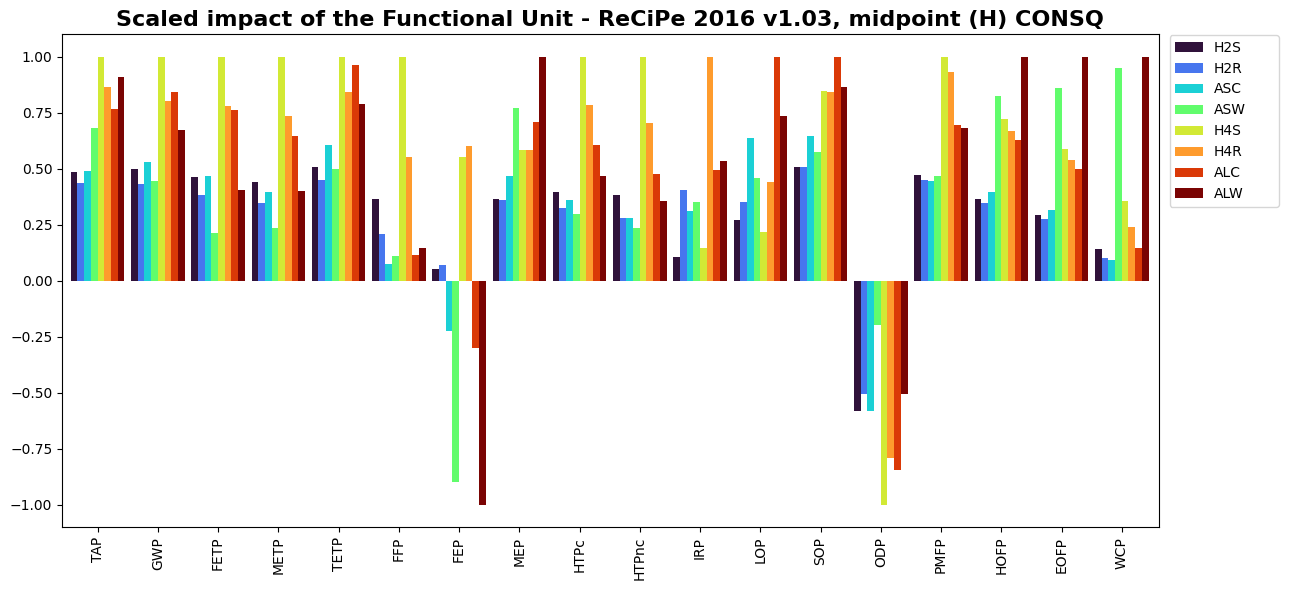

In [88]:
leg_pos_mid = .65

lp.scaled_FU_plot(df_scaled, plot_x_axis, inputs, impact_categories, leg_pos_mid)

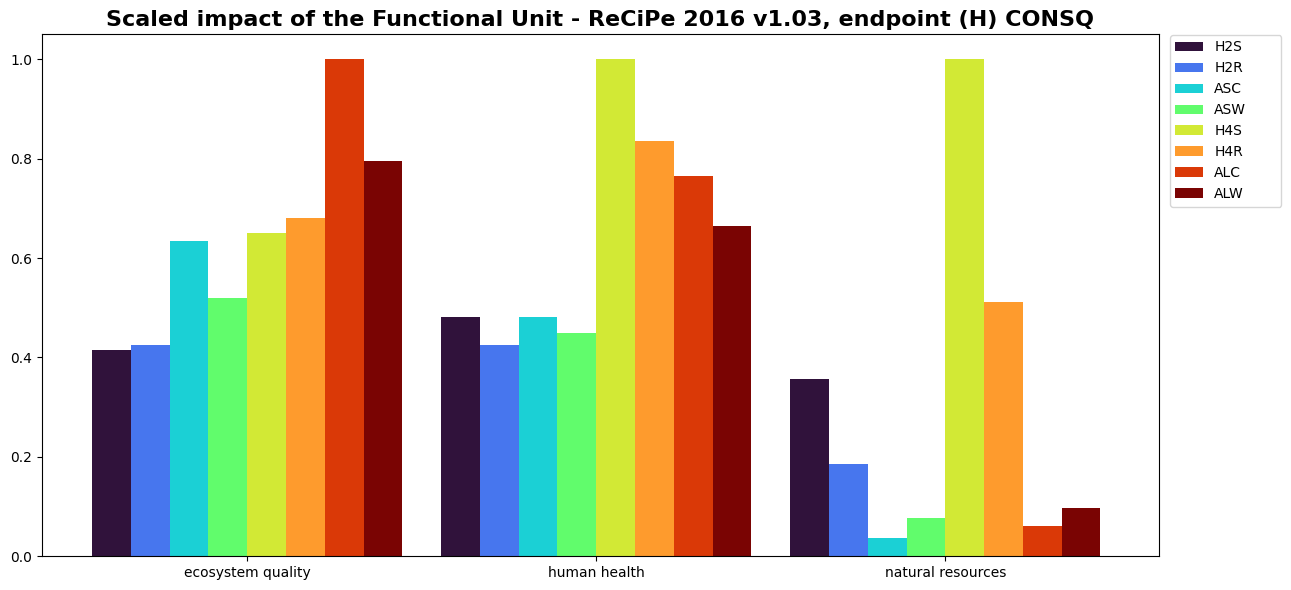

In [89]:
leg_pos_end = 0.67
if 'recipe' in lcia_method.lower():
    df_tot_e, df_scaled_e = lc.dataframe_element_scaling(df_endpoint)
    lp.scaled_FU_plot(df_scaled_e, plot_x_axis_end, inputs, impact_categories[-3:], leg_pos_end)


In [93]:
rl.reload_lib(lib)
columns = lc.unique_elements_list(database_name)
df_stack_updated, totals_df = lp.process_categorizing(df_GWP, db_type, database_name, 'break even', flow_legend, columns)
df_stack_updated

,Raw mat. + prod.,Disinfection,Autoclave,Recycling,Incineration,Avoided energy prod.,Avoided mat. prod.
H2S,0.231095,0.0,0.313619,0.0,0.17917,-0.224123,-0.006893
H2R,0.231095,0.0,0.313619,0.0,0.082418,-0.103097,-0.098885
ASC,0.110591,0.081384,0.418159,0.003019,0.000379,-0.000629,-0.09014
ASW,0.110591,0.041678,0.418159,0.003019,-0.002369,-0.04332,-0.09014
H4S,0.662563,0.0,0.470429,0.0,0.509229,-0.637647,-0.019612
H4R,0.662563,0.0,0.470429,0.0,0.233509,-0.293318,-0.282822
ALC,0.18543,0.162767,0.627239,0.005053,0.000757,-0.001257,-0.150855
ALW,0.18543,0.041678,0.627239,0.005053,-0.001991,-0.04332,-0.150855


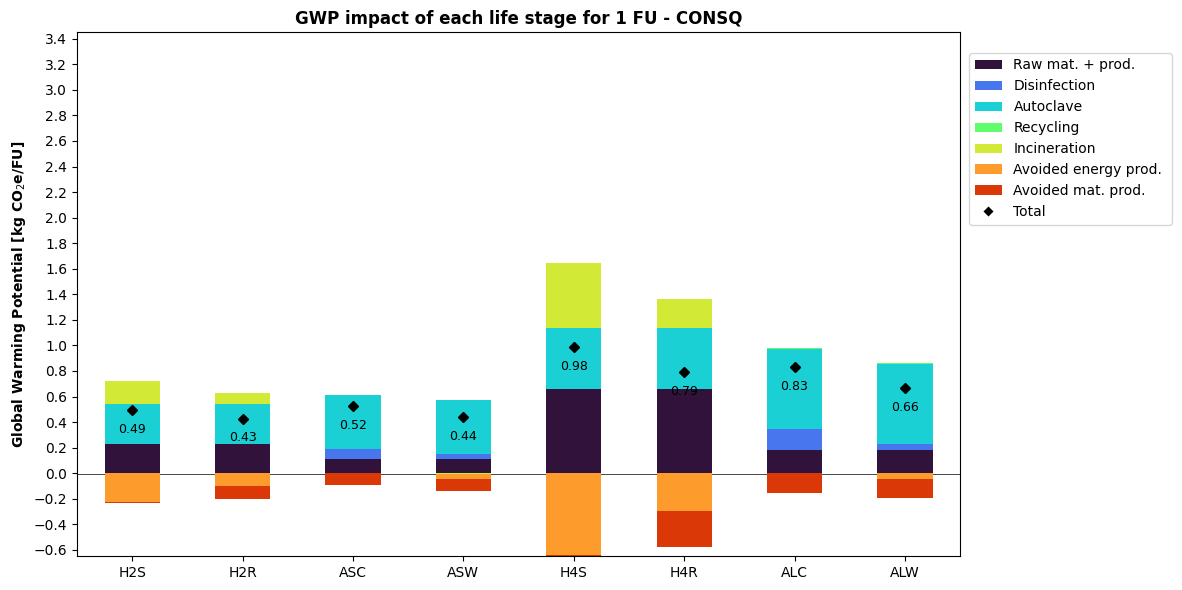

In [91]:
rl.reload_lib(lib)

y_min = -.6
y_max = 3.4
step = 0.2
leg_pos = 0.633
marker_offset = 0.2
y_axis_values = [y_min, y_max, step, leg_pos, marker_offset]
lp.gwp_scenario_plot(df_GWP, inputs, y_axis_values)


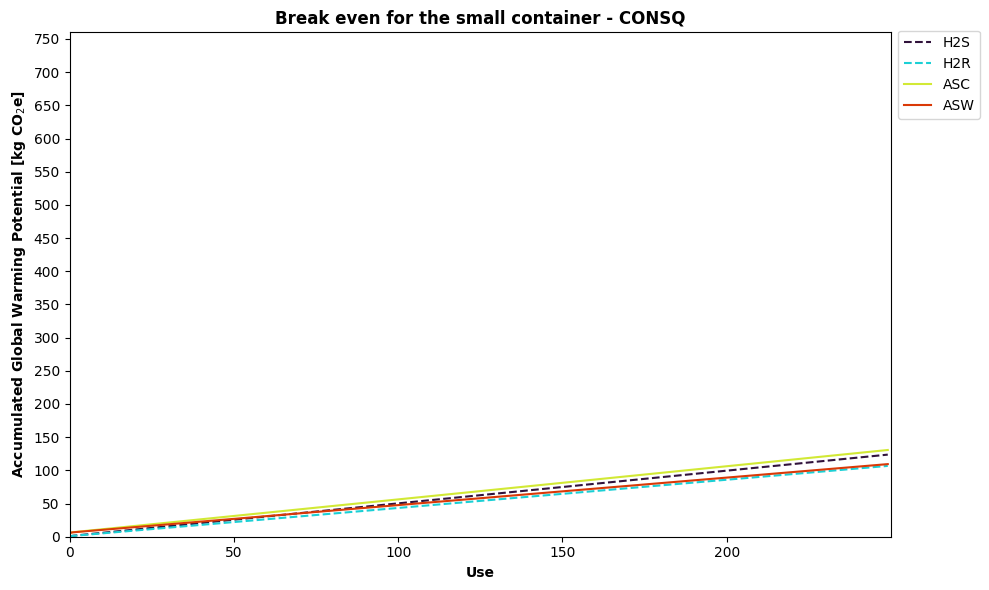

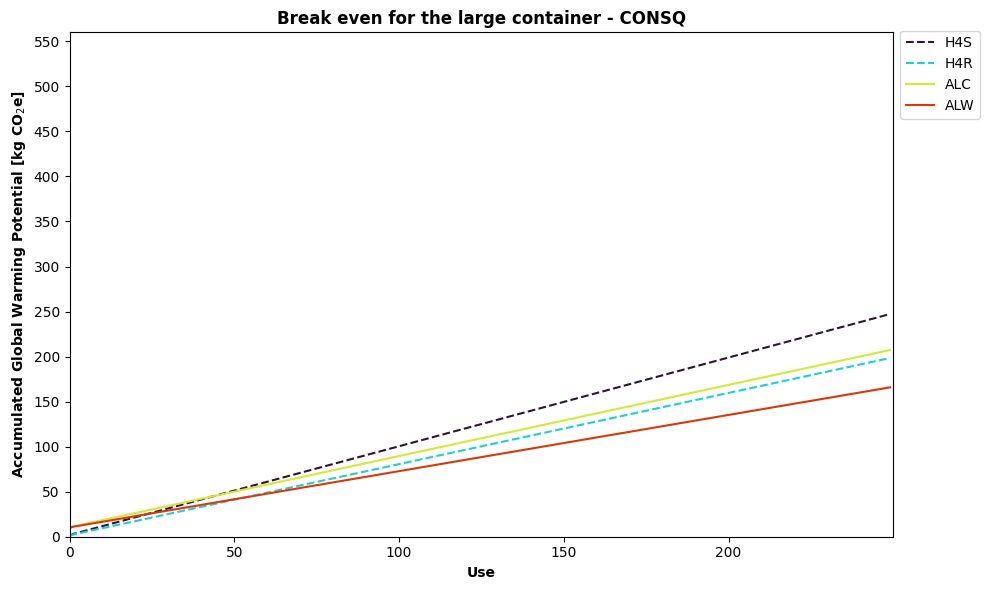

In [92]:
rl.reload_lib(lib)

amount_of_uses = 250
y_max = [750, 550]
ystep = [50, 50]
xstep = 50
break_even_product = 'container'
color_idx = [0, 2, 4, 6]

plot_controls = [amount_of_uses, y_max, ystep, xstep, break_even_product, color_idx]
lp.break_even_graph(df_GWP, inputs, plot_controls)

<class 'module'>
